In [39]:
#IMPORT DEPENDENCIES
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
from scipy.optimize import minimize
from MCForecastTools import MCSimulation
import warnings
import matplotlib.pyplot as plt


In [21]:
# Suppress the specific PerformanceWarning
warnings.filterwarnings('ignore', message='DataFrame is highly fragmented', category=pd.errors.PerformanceWarning)

In [22]:
#APIs
# Define the list of stock ticker symbols
tickers = ['AGG', 'BNDX', 'SPY', 'IVW', 'IVE', 'BTC-USD', 'ETH-USD']

# Calculate the start date (three years ago from today)
start_date = datetime.datetime.now() - datetime.timedelta(days=1095)

# Initialize an empty dataframe to store the Close columns for each ticker
new_df = pd.DataFrame()

# Initialize an empty list to store the column names of Close prices for each ticker
ticker_closes = []

In [23]:
#Past 3 years of data into data frames
# Iterate over each ticker symbol
for ticker in tickers:
    # Fetch historical stock price data for the current ticker
    stock_data = yf.download(ticker, start=start_date, end=datetime.datetime.now())
    
    # Extract the 'Close' column and rename it for the current ticker
    close_column = stock_data[['Close']].rename(columns={'Close': f'{ticker}_Close'})
    
    # Compute the daily returns and insert them to the left of the corresponding ticker's Close column
    daily_returns = close_column.pct_change().rename(columns={f'{ticker}_Close': f'{ticker}_Daily_Return'})
    new_df = pd.concat([daily_returns, new_df], axis=1)
    
    # Append the Close column name for the current ticker to the ticker_closes list
    ticker_closes.append(f'{ticker}_Close')

# Drop rows containing NaNs from the new_df dataframe
new_df.dropna(inplace=True)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [24]:
## Feel free to adjust or send feedback if the code could be better or be more precise to what is needed:

span = len(new_df)  # Adjust the span for three years of historical data

# Calculate the annualized exponentially weighted mean return for each asset
annualized_mean_return = new_df.ewm(span=span).mean().iloc[-1] * 252

# Calculate the annualized exponentially weighted standard deviation (risk) for each asset
annualized_std_dev = new_df.ewm(span=span).std().iloc[-1] * np.sqrt(252)

# Display annualized risk and return for each asset
for ticker in tickers:
    print(f'{ticker}:')
    print(f'Annualized Mean Return: {annualized_mean_return[f"{ticker}_Daily_Return"]:.2%}')
    print(f'Annualized Risk (Standard Deviation): {annualized_std_dev[f"{ticker}_Daily_Return"]:.2%}')
    print()

#print(new_df)

AGG:
Annualized Mean Return: -3.64%
Annualized Risk (Standard Deviation): 7.03%

BNDX:
Annualized Mean Return: -2.52%
Annualized Risk (Standard Deviation): 6.05%

SPY:
Annualized Mean Return: 14.13%
Annualized Risk (Standard Deviation): 16.05%

IVW:
Annualized Mean Return: 15.84%
Annualized Risk (Standard Deviation): 19.55%

IVE:
Annualized Mean Return: 12.10%
Annualized Risk (Standard Deviation): 14.18%

BTC-USD:
Annualized Mean Return: 31.93%
Annualized Risk (Standard Deviation): 51.49%

ETH-USD:
Annualized Mean Return: 12.67%
Annualized Risk (Standard Deviation): 61.05%



In [25]:
# Create a dictionary with calculated values
assets_data = {
    'Ticker': tickers,
    'Annualized_Mean_Return': [annualized_mean_return[f"{ticker}_Daily_Return"] for ticker in tickers],
    'Annualized_Std_Dev': [annualized_std_dev[f"{ticker}_Daily_Return"] for ticker in tickers]
}

# Convert the dictionary into a DataFrame
individual_assets = pd.DataFrame(assets_data)

# Print the DataFrame
print(individual_assets)

    Ticker  Annualized_Mean_Return  Annualized_Std_Dev
0      AGG               -0.036377            0.070326
1     BNDX               -0.025154            0.060471
2      SPY                0.141298            0.160477
3      IVW                0.158427            0.195470
4      IVE                0.120961            0.141762
5  BTC-USD                0.319274            0.514937
6  ETH-USD                0.126703            0.610512


In [26]:
agg_mean_return = individual_assets['Annualized_Mean_Return']

# Define the objective function to minimize
def objective_function(weights, mean_returns, target_return):
    # Calculate the portfolio return
    portfolio_return = np.dot(mean_returns, weights)
    # Calculate the squared difference between the portfolio return and the target return
    return (portfolio_return - target_return) ** 2

# Define initial guess for weights
initial_guess = np.ones(len(agg_mean_return)) / len(agg_mean_return)  # Equal weights initially

# List of target return percentages
target_returns = [0.05, 0.10, 0.15, .20, .25, .30, 0.35]  # Add more target returns as needed

# Initialize an empty dataframe to store the results
target_weights = pd.DataFrame()

# Define constraint function to ensure weights sum to 1
def constraint(weights):
    return np.sum(weights) - 1

# Loop through each target return
for i, target_return in enumerate(target_returns, start=1):
    # Perform optimization
    result = minimize(objective_function, initial_guess, args=(agg_mean_return, target_return), method='SLSQP', bounds=[(0, 1)] * len(agg_mean_return), constraints={'type': 'eq', 'fun': constraint})

    # Print optimization result
    # print(f"Optimization Result for Target Return {target_return}:")
    # print(result)
    # print("Optimal solution:", result.x)

    # Round the optimal solution to a certain number of decimal places
    rounded_solution = np.round(result.x, decimals=4)

    # Ensure that the rounded weights sum up to 1
    rounded_solution /= np.sum(rounded_solution)

    # Print the rounded and normalized solution
    print("Optimal solution (rounded and normalized):", rounded_solution)

    # Store the rounded and normalized solution in the dataframe
    target_weights[f'{target_return}_weights'] = rounded_solution

# Print the dataframe with the results
# print("Target Weights:")
target_weights


Optimal solution (rounded and normalized): [0.26057394 0.25157484 0.11838816 0.10468953 0.13468653 0.
 0.13008699]
Optimal solution (rounded and normalized): [0.1690169  0.1670167  0.13831383 0.13541354 0.14181418 0.10761076
 0.14081408]
Optimal solution (rounded and normalized): [0.082  0.0865 0.1534 0.1603 0.1452 0.225  0.1476]
Optimal solution (rounded and normalized): [0.         0.00279972 0.16768323 0.18468153 0.14758524 0.34406559
 0.15318468]
Optimal solution (rounded and normalized): [0.     0.     0.1106 0.1584 0.0538 0.6074 0.0698]
Optimal solution (rounded and normalized): [0.     0.     0.0174 0.1006 0.     0.882  0.    ]
Optimal solution (rounded and normalized): [0. 0. 0. 0. 0. 1. 0.]


,0.05_weights,0.1_weights,0.15_weights,0.2_weights,0.25_weights,0.3_weights,0.35_weights
0,0.260574,0.169017,0.0820,0.000000,0.0000,0.0000,0.0
1,0.251575,0.167017,0.0865,0.002800,0.0000,0.0000,0.0
2,0.118388,0.138314,0.1534,0.167683,0.1106,0.0174,0.0
3,0.104690,0.135414,0.1603,0.184682,0.1584,0.1006,0.0
4,0.134687,0.141814,0.1452,0.147585,0.0538,0.0000,0.0
5,0.000000,0.107611,0.2250,0.344066,0.6074,0.8820,1.0
6,0.130087,0.140814,0.1476,0.153185,0.0698,0.0000,0.0


In [27]:
#CONFIRM PORT RETURNS MATCH TARGETS FROM SOLVER
for i, target_weight_column in enumerate(target_weights.columns):
    
    # Calculate portfolio return using sum product
    portfolio_return = (np.dot(target_weights[target_weight_column], individual_assets['Annualized_Mean_Return'])) * 100

    print("Portfolio Return:", round(portfolio_return, 2))

# target_weights

Portfolio Return: 5.03
Portfolio Return: 10.0
Portfolio Return: 15.0
Portfolio Return: 20.0
Portfolio Return: 25.0
Portfolio Return: 30.0
Portfolio Return: 31.93


In [28]:
# Calculate the correlation matrix
correlation_matrix = new_df.corr()
#print(correlation_matrix)

# Get the column names for the weights based on target return percentages
weight_columns = [col for col in target_weights.columns if col.endswith('_weights')]

# Access the values of these columns and store them in the weights variable
weights = target_weights[weight_columns].values.T

# Define a function to calculate portfolio standard deviation
def calculate_portfolio_std(weights, correlation_matrix, std_deviations):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(correlation_matrix, weights)) * np.sum(std_deviations ** 2))
    return portfolio_std

# Create a new DataFrame to store portfolio standard deviations
port_stds = pd.DataFrame(index=[f"Portfolio {i}" for i in range(1, 8)], columns=['Portfolio_Std_Dev'])

# Iterate over each row in the DataFrame
for index, row in target_weights.iterrows():
    # Extract weights and standard deviations from the current row
    weights = row[weight_columns].values
for index, row in individual_assets.iterrows():
    std_deviations = row['Annualized_Std_Dev']

    portfolio_std = calculate_portfolio_std(weights, correlation_matrix, std_deviations)
    
    # Add portfolio standard deviation to the port_stds DataFrame
    port_stds.at[f"Portfolio {index + 1}", 'Portfolio_Std_Dev'] = portfolio_std

# Print the DataFrame with portfolio standard deviations
print(port_stds)

            Portfolio_Std_Dev
Portfolio 1          0.036445
Portfolio 2          0.031338
Portfolio 3          0.083163
Portfolio 4          0.101297
Portfolio 5          0.073464
Portfolio 6          0.266852
Portfolio 7          0.316381


In [29]:
##NOTE were only going to use 10-30% Return Portfolios for analysis

for i, target_weight_column in enumerate(target_weights.columns[1:-1]):
    # Calculate portfolio return using sum product
    portfolio_return = (np.dot(target_weights[target_weight_column], individual_assets['Annualized_Mean_Return'])) * 100
    
    # Calculate portfolio Sharpe ratio
    portfolio_std_dev = port_stds.iloc[i + 1]['Portfolio_Std_Dev']
    portfolio_sharpe = portfolio_return / (portfolio_std_dev * 100)
    
    # Print portfolio return and Sharpe ratio
    print(f"Portfolio Return: {round(portfolio_return, 2)}%")
    print("Portfolio Sharpe:", round(portfolio_sharpe, 2))
    print('--------')


Portfolio Return: 10.0%
Portfolio Sharpe: 3.19
--------
Portfolio Return: 15.0%
Portfolio Sharpe: 1.8
--------
Portfolio Return: 20.0%
Portfolio Sharpe: 1.97
--------
Portfolio Return: 25.0%
Portfolio Sharpe: 3.4
--------
Portfolio Return: 30.0%
Portfolio Sharpe: 1.12
--------


In [30]:
monte_df = pd.DataFrame()

# Get the column names for the weights based on target return percentages
weight_columns = [col for col in target_weights.columns if col.endswith('_weights')]

# Access the values of these columns and store them in the weights variable
weights = target_weights[weight_columns].values.T
# print(sum(list(weights[0])))
# print(sum(list(weights[1])))

# Iterate over each ticker symbol
for ticker in tickers:
    # Fetch historical stock price data for the current ticker
    stock_data = yf.download(ticker, start=start_date, end=datetime.datetime.now())
    
    stock_data = stock_data[['Close']].rename(columns={'Close': 'close'})
  
    existing_columns = stock_data.columns

    # Create a MultiIndex with a single top level and the existing column names as the second level
    multi_index = pd.MultiIndex.from_product([[ticker], existing_columns])

    # Set the MultiIndex as the columns of the DataFrame
    stock_data.columns = multi_index

    monte_df = pd.concat([stock_data, monte_df], axis=1)

# Drop rows containing NaNs from the new_df dataframe
monte_df.dropna(inplace=True)

monte_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,ETH-USD,BTC-USD,IVE,IVW,SPY,BNDX,AGG
,close,close,close,close,close,close,close
Date,,,,,,,
2021-05-10,3952.293945,55859.796875,150.610001,67.940002,417.940002,56.910000,114.430000
2021-05-11,4168.701172,56704.574219,148.570007,67.650002,414.209991,56.779999,114.180000
2021-05-12,3785.848633,49150.535156,145.990005,65.959999,405.410004,56.619999,113.779999
2021-05-13,3715.148438,49716.191406,147.979996,66.660004,410.279999,56.639999,114.040001
2021-05-14,4079.057373,49880.535156,149.820007,67.889999,416.579987,56.709999,114.300003
...,...,...,...,...,...,...,...
2024-05-01,2969.784668,58254.011719,178.360001,80.809998,500.350006,48.410000,95.269997
2024-05-02,2988.168457,59123.433594,179.360001,81.849998,505.029999,48.509998,95.699997


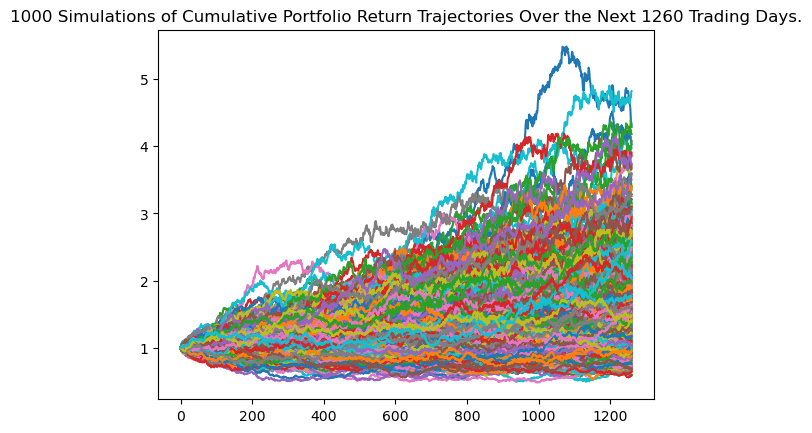

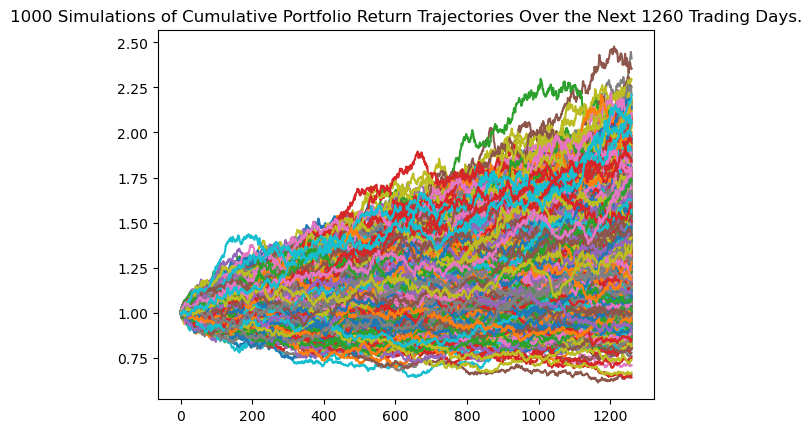

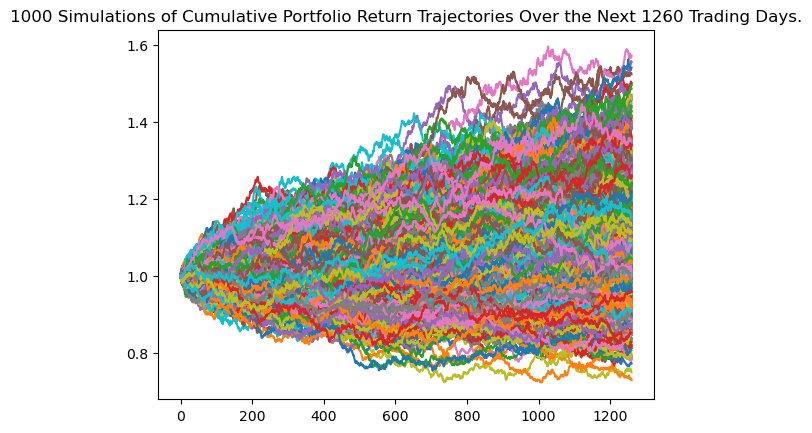

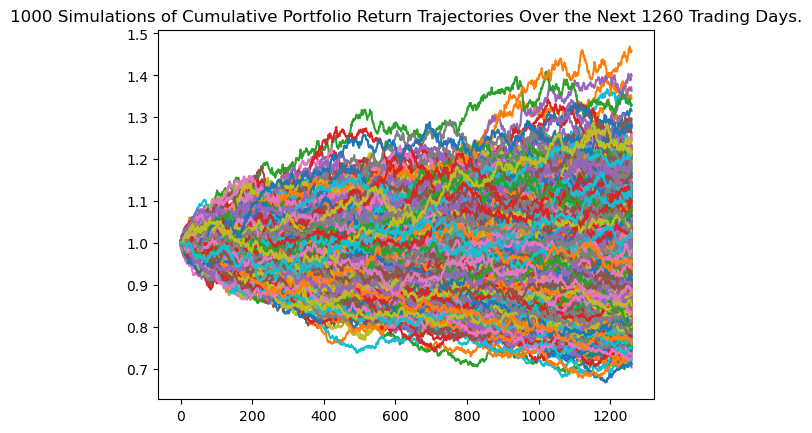

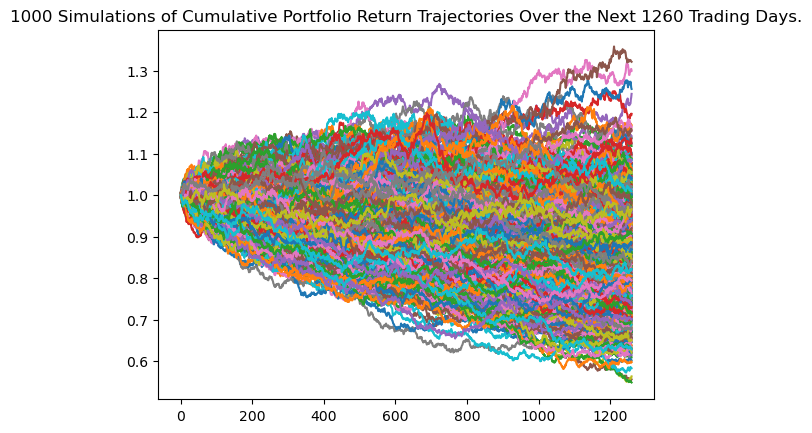

In [31]:
# Create an empty dictionary to store MCSimulation instances
MC_ports = {}
num_sims = 1000
forecast_years = 5
portfolios = len(list(weights[1:-1]))

# Iterate over the range of portfolios
for i in range(1, portfolios+1):
    # Generate the weights dynamically based on the loop index
    weights_i = list(weights[i])

    # Create an instance of MCSimulation and store it in the dictionary
    MC_ports[f'MC_port_{i}'] = MCSimulation(monte_df, weights=weights_i, num_simulation=num_sims, num_trading_days=252*forecast_years)

    # Print the simulation input data for the current MCSimulation instance
    # print(f"MC_port_{i} simulation input data:")
    # print(MC_ports[f'MC_port_{i}'].portfolio_data.head())

    line_plot = MC_ports[f'MC_port_{i}'].plot_simulation()
    line_plot.get_figure().savefig(f'MC_port_{i}_{forecast_years}year_sim_plot.png', bbox_inches='tight')
    


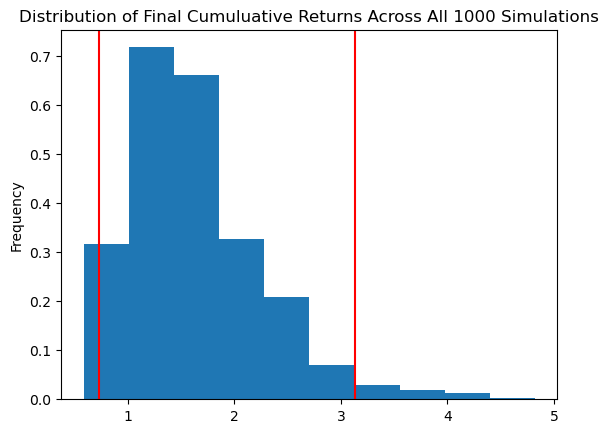

In [40]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ports['MC_port_1'].plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig(f'MC_port_one_{forecast_years}_dist_plot.png', bbox_inches = 'tight')

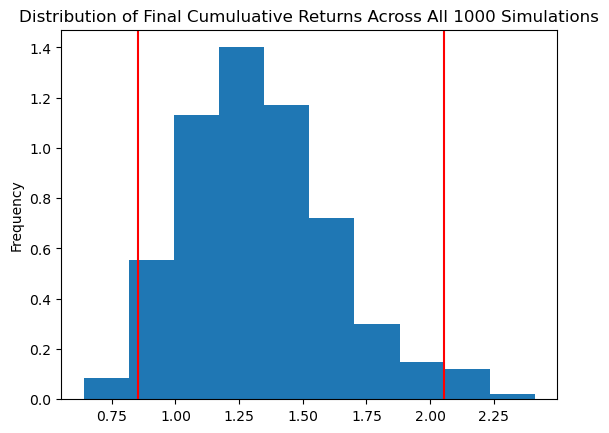

In [38]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ports['MC_port_2'].plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig(f'MC_port_two_{forecast_years}year_dist_plot.png', bbox_inches = 'tight')

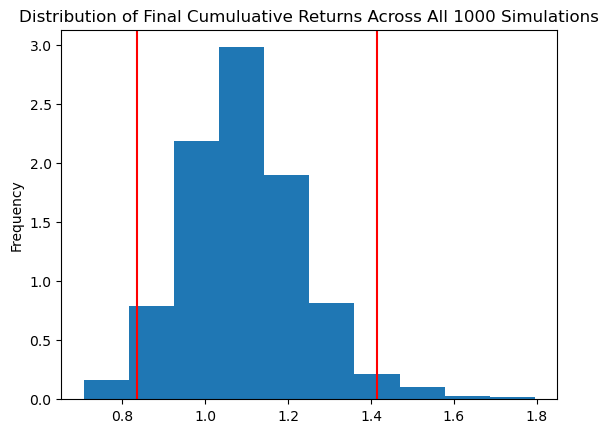

In [15]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ports['MC_port_3'].plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig(f'MC_port_three_{forecast_years}year_dist_plot.png', bbox_inches = 'tight')

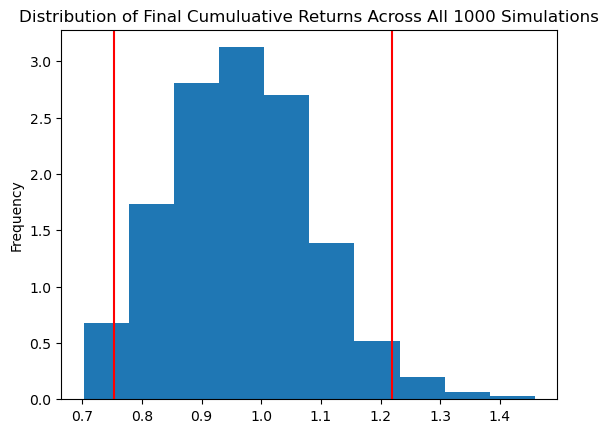

In [34]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ports['MC_port_4'].plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig(f'MC_port_four_{forecast_years}year_dist_plot.png', bbox_inches = 'tight')

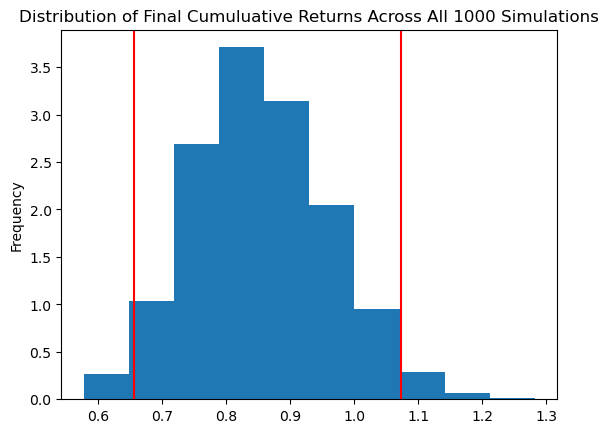

In [17]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ports['MC_port_5'].plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig(f'MC_port_five_{forecast_years}year_dist_plot.png', bbox_inches = 'tight')

In [35]:
##**NOTE** I STILL THINK THESE ARE BACKWARDS.... BUT WHY?? WEIGHTS??

# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
portfolio_num = 1

for key in MC_ports:
    summary_metrics = MC_ports[key].simulated_return.iloc[-1].describe()
    ci_series_port = MC_ports[key].confidence_interval
    ci_series_port.index = ["95% CI Lower", "95% CI Upper"]

    # Concatenate metrics and confidence interval series into a DataFrame
    summary_df_port = pd.concat([summary_metrics, ci_series_port], axis=0)

    # Print summary statistics with confidence intervals
    print(f"Metrics for Portfolio {portfolio_num}:")
    print('')
    print(summary_df_port)
    

    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
    initial_investment = 15000
    lower_bound_port = round((summary_df_port['95% CI Lower'] * initial_investment), 2)
    upper_bound_port = round((summary_df_port['95% CI Upper'] * initial_investment), 2)

    # Print results
    print('')
    print(f"There is a 95% chance that an initial investment of ${initial_investment}")
    print(f"in Portofolio {portfolio_num} over the next {forecast_years} years will end within the range of ${lower_bound_port} and ${upper_bound_port}.")

    sharpe_port = summary_df_port['mean']/summary_df_port['std']
    print(f"Portfolio {portfolio_num} Sharpe: {round(sharpe_port, 2)}, you make {round(sharpe_port,2)} units of return for every 1 unit of risk")

    # set equal portfolio metrics
    risk_reward_port = round((upper_bound_port- initial_investment)/abs(lower_bound_port - initial_investment), 2)
    sharpe_port = summary_df_port['mean']/summary_df_port['std']
    risk_adjusted_efficiency = round((risk_reward_port / sharpe_port), 2)
    print("--------")
    print(f"Initial Investment: ${initial_investment}")
    print('')
    print(f'Upper and Lower Bounds of Portfolio {portfolio_num}: ${upper_bound_port} and ${lower_bound_port}')
    print(f"Portfolio {portfolio_num} Max Profit: ${round((upper_bound_port - initial_investment), 2)}")
    print(f"Portfolio {portfolio_num} Max Loss: $ {round((lower_bound_port - initial_investment), 2)}")
    print(f"Portfolio {portfolio_num} Risk-Reward Ratio: {risk_reward_port}")
    print(f"Portfolio {portfolio_num} Simulation Sharpe: {round(sharpe_port, 2)}")
    print(f"Portfolio {portfolio_num} Risk-Adjusted Efficiency: {risk_adjusted_efficiency}")


    print('------------------------')
    print('------------------------')
    print('------------------------')

    portfolio_num += 1

Metrics for Portfolio 1:

count           1000.000000
mean               1.634081
std                0.629010
min                0.587032
25%                1.176104
50%                1.519754
75%                1.968445
max                4.821366
95% CI Lower       0.729547
95% CI Upper       3.132144
Name: 1260, dtype: float64

There is a 95% chance that an initial investment of $15000
in Portofolio 1 over the next 5 years will end within the range of $10943.21 and $46982.15.
Portfolio 1 Sharpe: 2.6, you make 2.6 units of return for every 1 unit of risk
--------
Initial Investment: $15000

Upper and Lower Bounds of Portfolio 1: $46982.15 and $10943.21
Portfolio 1 Max Profit: $31982.15
Portfolio 1 Max Loss: $ -4056.79
Portfolio 1 Risk-Reward Ratio: 7.88
Portfolio 1 Simulation Sharpe: 2.6
Portfolio 1 Risk-Adjusted Efficiency: 3.03
------------------------
------------------------
------------------------
Metrics for Portfolio 2:

count           1000.000000
mean               1.33376